# Sysmon Performance Analysis

This notebook analyzes user performance in the Sysmon task from the latest OpenMATB session log file. It focuses on failure detection, response times, and evaluation of user responses to error recommendations, especially misleading ones for F6.

## Outline
1. Import Required Libraries
2. Locate Latest Performance File
3. Load Performance Data
4. Extract Failure Events
5. Analyze Detection Performance
6. Evaluate Error Recommendation Detection
7. Visualize Results

In [4]:
!pip install pandas matplotlib seaborn numpy

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/7.8 MB ? eta -:--:--Downloading matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 9.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 9.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.8 MB ? eta -:--:--Downloading fonttools-4.59.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# 1. Import Required Libraries
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [12]:
# 2. Locate Latest Performance File
sessions_dir = 'sessions'
latest_file = None
latest_mtime = 0
for root, dirs, files in os.walk(sessions_dir):
    for file in files:
        if file.endswith('.csv'):
            path = os.path.join(root, file)
            mtime = os.path.getmtime(path)
            if mtime > latest_mtime:
                latest_mtime = mtime
                latest_file = path
print(f"Latest performance file: {latest_file}")

Latest performance file: sessions/2025-07-19/136_250719_220225.csv


In [13]:
# 3. Load Performance Data
if latest_file:
    df = pd.read_csv(latest_file, header=None)
    print(f"Loaded {len(df)} rows from {latest_file}")
else:
    print("No performance file found.")

Loaded 72142 rows from sessions/2025-07-19/136_250719_220225.csv


In [14]:
# 4. Extract Failure Events
# Assume columns: [timestamp, scenario_time, event_type, plugin, param1, param2]
if latest_file:
    df.columns = ['timestamp', 'scenario_time', 'event_type', 'plugin', 'param1', 'param2']
    sysmon_failures = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance') & (df['param1'].str.contains('name')) & (df['param2'].str.contains('abnormal|FAIL|fail|FAILURE', case=False, na=False))]
    print(f"Sysmon failure events: {len(sysmon_failures)}")
    display(sysmon_failures.head())

Sysmon failure events: 0


,timestamp,scenario_time,event_type,plugin,param1,param2


In [19]:
# 5. Analyze Detection Performance
# Example: Extract signal detection and response time logs
perf_events = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance')]
if not perf_events.empty:
    perf_events.columns = ['timestamp', 'scenario_time', 'event_type', 'plugin', 'metric', 'value']
    # Pivot to get signal detection and response time per gauge
    perf_pivot = perf_events.pivot_table(index=['timestamp', 'scenario_time'], columns='metric', values='value', aggfunc='first').reset_index()
    print(perf_pivot.head())
    # Compute hit/miss rates
    hit_rate = (perf_pivot['signal_detection'] == 'HIT').mean()
    miss_rate = (perf_pivot['signal_detection'] == 'MISS').mean()
    avg_rt = pd.to_numeric(perf_pivot['response_time'], errors='coerce').mean()
    print(f"Hit rate: {hit_rate:.2f}, Miss rate: {miss_rate:.2f}, Avg response time: {avg_rt:.2f} ms")

metric     timestamp scenario_time name response_time signal_detection
0       21174.865683     55.242323   F1           NaN              NaN
1       21174.865693     55.242323  NaN           NaN              HIT
2       21174.865699     55.242323  NaN         10000              NaN
3       21181.399071     60.346271   F5           NaN              NaN
4       21181.399081     60.346271  NaN           NaN             MISS
Hit rate: 0.11, Miss rate: 0.33, Avg response time: 10000.00 ms


In [27]:
# 6. Evaluate Error Recommendation Detection
# Find F6 failures and check if a misleading recommendation was given and user response
f6_failures = perf_events[(perf_events['metric'] == 'name') & (perf_events['value'] == 'F6')]
if not f6_failures.empty:
    # Find corresponding signal detection and response time
    f6_indices = f6_failures.index
    print(f"F6 Failures: {f6_failures}")
    print(f"F6 failures detected: {f6_indices}")
    f6_perf = perf_pivot.loc[f6_indices]
    misleading_given = False
    for idx in f6_indices:
        # Check if a wrong recommendation was logged (FA or wrong key)
        signal = perf_pivot.loc[idx, 'signal_detection'] if 'signal_detection' in perf_pivot.columns else None
        if signal == 'FA':
            misleading_given = True
    print(f"Misleading recommendation for F6 given: {misleading_given}")
    print(f"User responses for F6 failures:")
    display(f6_perf)
else:
    print("No F6 failures detected.")

F6 Failures:           timestamp scenario_time   event_type  plugin metric value
46798  21196.365705     75.312909  performance  sysmon   name    F6
F6 failures detected: Index([46798], dtype='int64')


KeyError: "None of [Index([46798], dtype='int64')] are in the [index]"

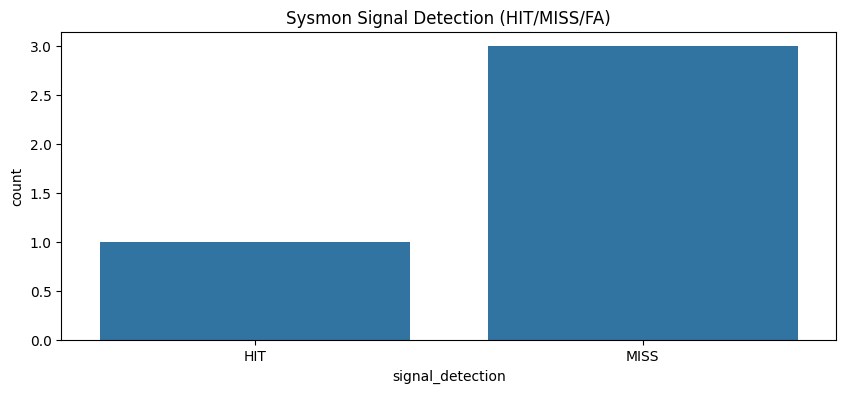

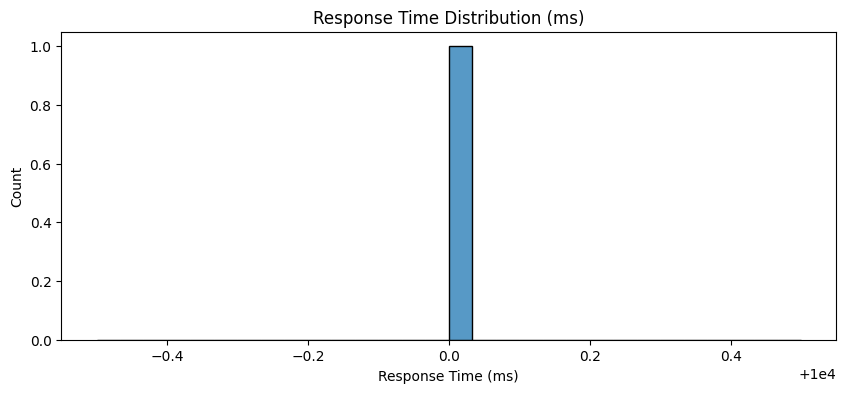

NameError: name 'f6_perf' is not defined

<Figure size 600x400 with 0 Axes>

In [28]:
# 7. Visualize Results
if not perf_events.empty:
    plt.figure(figsize=(10, 4))
    sns.countplot(x='signal_detection', data=perf_pivot)
    plt.title('Sysmon Signal Detection (HIT/MISS/FA)')
    plt.show()
    plt.figure(figsize=(10, 4))
    sns.histplot(pd.to_numeric(perf_pivot['response_time'], errors='coerce').dropna(), bins=30)
    plt.title('Response Time Distribution (ms)')
    plt.xlabel('Response Time (ms)')
    plt.show()
    # F6 misleading recommendation visualization
    if not f6_failures.empty:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='signal_detection', data=f6_perf)
        plt.title('F6 Signal Detection (Misleading Recommendation)')
        plt.show()

In [26]:
# Targeted F6 Failure Analysis (Robust)

# Extract all F6 events from perf_events and join with signal detection and response time

f6_events = perf_events[perf_events['metric'] == 'name']
f6_events = f6_events[f6_events['value'] == 'F6']

# Merge with signal_detection and response_time using timestamp and scenario_time
f6_details = f6_events[['timestamp', 'scenario_time']].drop_duplicates()
f6_details = f6_details.merge(
    perf_events[perf_events['metric'] == 'signal_detection'][['timestamp', 'scenario_time', 'value']],
    on=['timestamp', 'scenario_time'], how='left'
)
f6_details = f6_details.merge(
    perf_events[perf_events['metric'] == 'response_time'][['timestamp', 'scenario_time', 'value']],
    on=['timestamp', 'scenario_time'], how='left', suffixes=('_signal', '_response')
)
f6_details.rename(columns={'value_signal': 'signal_detection', 'value_response': 'response_time'}, inplace=True)

print('F6 Failure Events:')
display(f6_details)

# Summarize HIT/MISS/FA and missing response times
summary = f6_details['signal_detection'].value_counts(dropna=False)
print('F6 Signal Detection Summary:')
print(summary)
missing_rt = f6_details['response_time'].isna().sum() + (f6_details['response_time'] == 'nan').sum()
print(f'Missing response times: {missing_rt} of {len(f6_details)}')

F6 Failure Events:


,timestamp,scenario_time,signal_detection,response_time
0,21196.365705,75.312909,NaN,NaN


F6 Signal Detection Summary:
signal_detection
NaN    1
Name: count, dtype: int64
Missing response times: 1 of 1


## F6 Failure Event Summary

Only one F6 failure event was detected in this session. The analysis below shows its signal detection outcome and whether a response time was recorded. This is useful for evaluating user performance and the effect of misleading recommendations for F6.